In [571]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from keras.utils import to_categorical
from keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import shuffle
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support, roc_curve, roc_auc_score
from keras.regularizers import l2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [212]:
pima_df = pd.read_csv('diabetes.csv')
pima_df = shuffle(pima_df)

In [213]:
labels = pima_df['Outcome']
features = pima_df.drop('Outcome', axis = 1)

In [214]:
features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
138,0,129,80,0,0,31.2,0.703,29
260,3,191,68,15,130,30.9,0.299,34
755,1,128,88,39,110,36.5,1.057,37
645,2,157,74,35,440,39.4,0.134,30
175,8,179,72,42,130,32.7,0.719,36


In [215]:
scaler = MinMaxScaler(feature_range=(.05, .95))

continous = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [192]:
means = features[continous].mean()
means

Glucose                     120.894531
BloodPressure                69.105469
SkinThickness                20.536458
Insulin                      79.799479
BMI                          31.992578
DiabetesPedigreeFunction      0.471876
Age                          33.240885
dtype: float64

In [216]:
features['Pregnancies'] = features['Pregnancies'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], 1)

In [217]:
features[continous] = scaler.fit_transform(features[continous])

In [81]:
split_num = 0.9
test_train_split = int(len(features)* split_num)
train_features, test_features = features[:test_train_split], features[test_train_split:]
train_labels, test_labels = labels[:test_train_split], labels[test_train_split:]

In [590]:
input_shape = features.shape[1]

model = Sequential()
model.add(Dense(24, input_shape = (input_shape,), activation = 'relu', activity_regularizer = l2(0.001)))#24 32
model.add(Dropout(.4))
model.add(Dense(32, activation = 'relu', activity_regularizer = l2(0.001)))#32
model.add(Dropout(.4))
model.add(Dense(1, activation = 'sigmoid'))

In [591]:
model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr=0.001, momentum = 0.9), metrics = ['accuracy'])

In [521]:
checkpointer = ModelCheckpoint(filepath = 'pima_weights2.hdf5', monitor = 'val_loss', save_best_only = True)

In [522]:
history = model.fit(train_features, train_labels, epochs = 3000, validation_split = 0.15, batch_size = 32, verbose = 0, callbacks = [checkpointer])

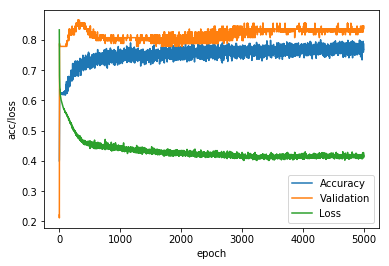

In [523]:
plt.plot(history.history['acc'], label = 'Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation')
plt.plot(history.history['val_loss'], label = 'Loss')
plt.xlabel('epoch')
plt.ylabel('acc/loss')
plt.legend()
plt.show()

In [592]:
score = model.evaluate(test_features, test_labels)
score

77/77 [==============================] - 8s 107ms/step


[0.7175851611347942, 0.70129870516913273]

In [593]:
model.load_weights('pima_weights1.hdf5')

In [594]:
score = model.evaluate(test_features, test_labels)
score

77/77 [==============================] - 0s 157us/step


[0.45334654736828495, 0.85714285791694345]

In [598]:
evals = []
preds = model.predict(test_features)
for i in preds:
    if i > .4:
        evals.append(1)
    else:
        evals.append(0)

In [599]:
cm = confusion_matrix(test_labels, evals)
cm

array([[47,  7],
       [ 5, 18]])

In [600]:
precision_recall_fscore_support(test_labels, evals)

(array([ 0.90384615,  0.72      ]),
 array([ 0.87037037,  0.7826087 ]),
 array([ 0.88679245,  0.75      ]),
 array([54, 23]))

In [ ]:
acc: 72.73%
acc: 74.03%
acc: 79.22%
acc: 75.32%
acc: 75.32%
acc: 76.62%
acc: 81.82%
acc: 72.73%
acc: 75.00%
acc: 85.53%
76.83% (+/- 3.95%)

acc: 74.03%
acc: 75.32%
acc: 81.82%
acc: 77.92%
acc: 75.32%
acc: 74.03%
acc: 81.82%
acc: 74.03%
acc: 75.00%
acc: 80.26%
76.95% (+/- 3.07%)

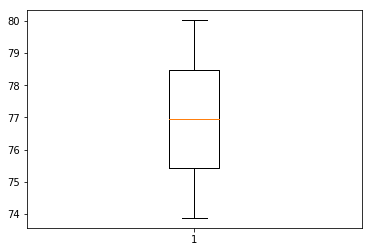

In [604]:
data2 = [76.95, 80.02, 73.88]
fig, ax1 = plt.subplots()
ax1.boxplot(data2)
plt.show()

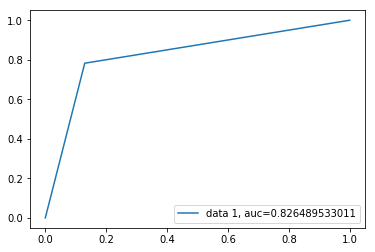

In [603]:
auc = roc_auc_score(test_labels, evals)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()